## Importing of required libraries


In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

import copy

from sklearn.metrics import confusion_matrix

import requests
from PIL import Image
from io import BytesIO

In [2]:
T = transforms.Compose([
    transforms.ToTensor()
])
# transforms.ToTensor => 
# Converts the image into numbers, that are understandable by the system. 
# It separates the image into three color channels (separate images): red, green & blue.
# Then it converts the pixels of each image to the brightness of their color between 0 and 255.
# These values are then scaled down to a range between 0 and 1
# The image is now a torch tensor (a multi-dimensional matrix containing elements of a single data type). 

In [3]:
# Set the batch size to 64
numb_batch = 64

## Getting the Data


In [4]:
# Downloading datasets
train_data = datasets.MNIST('mnist_data_train', train=True, download=True, transform=T)
test_data = datasets.MNIST('mnist_data_test', train=False, download=True, transform=T)

In [5]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=numb_batch, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=numb_batch, shuffle=True)

## Knowing The Dataset Better


In this phase, we will be doing some exploratory data analysis on our images and tensors


In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


images.shape = There are 64 images in each batch and each image has a dimension of 28 x 28 pixels.<br/>
labels.shape = 64 images have 64 labels respectively.


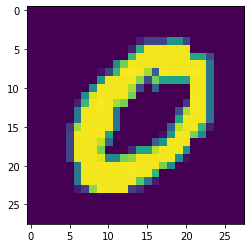

In [7]:
plt.imshow(images[0].numpy().squeeze())

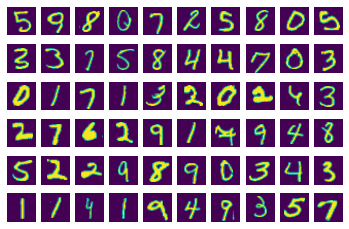

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze())

## Creating the Model


In [9]:
# Creating LeNet architecture:
# conv_out = [(W - K + 2P)/S] + 1
# conv1 = (28 - 5 + 2*2)/1 + 1 = 28 ===> 28 * 28 * 6 = 4704 params
# avg pool1 = (28-2)/2 + 1 = 14 ===> 14 * 14 * 6 = 1176
# conv2 = (14 - 5 + 2*0)/1 + 1 = 10 ===> 10 * 10 * 16 = 1600 params
# avg pool2 = (10 - 2)/2 + 1 = 5 ===> 5 * 5 * 16 = 400 params
def create_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.Tanh(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10)
    )
    return model

## Validating the Model


In [10]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1) # 64 images - each will correspond to one predicted value from the max probability of 10 neurons
        total = total + x.size(0)
        correct = correct + torch.sum(pred.data == labels)
    return correct*100./total

## Training Function


In [11]:
def train(num_epoch=3, lr=0.001):
    accuracies = []
    cnn_model = create_model()
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr)
    max_accuracy = 0.
    for epoch in range(num_epoch):
        for i, (images, labels) in enumerate(trainloader):
            optimizer.zero_grad() # initialize zero gradients to neurons for each batch of images
            prediction = cnn_model(images) # get (probabilities) predicted values (ouput-linear = 10) for each image (total = 64) from forward propogation
            loss = loss_function(prediction, labels) # calculate loss (CrossEntropyLoss) from the predicted values
            loss.backward() # do backward propogation to calculate the gradients of each neuron
            optimizer.step() # optimize the model by taking a step acc to lr
        # validate the model after each epoch with optimized steps taken
        accuracy = float(validate(cnn_model, testloader))
        accuracies.append(accuracy)
        if (accuracy > max_accuracy):
            best_model = copy.deepcopy(cnn_model)
            max_accuracy = accuracy
            print("Saving best model with accuract: ",accuracy)
        print("Epoch: ", epoch+1, " Accuracy: ", accuracy)
    plt.plot(accuracies)
    return best_model
        

## Training the Model


Saving best model with accuract:  96.61000061035156
Epoch:  1  Accuracy:  96.61000061035156
Saving best model with accuract:  97.44000244140625
Epoch:  2  Accuracy:  97.44000244140625
Saving best model with accuract:  97.97000122070312
Epoch:  3  Accuracy:  97.97000122070312
Epoch:  4  Accuracy:  97.79000091552734
Saving best model with accuract:  98.0
Epoch:  5  Accuracy:  98.0
Saving best model with accuract:  98.36000061035156
Epoch:  6  Accuracy:  98.36000061035156
Saving best model with accuract:  98.52999877929688
Epoch:  7  Accuracy:  98.52999877929688
Epoch:  8  Accuracy:  98.45999908447266
Epoch:  9  Accuracy:  98.51000213623047
Epoch:  10  Accuracy:  98.45999908447266


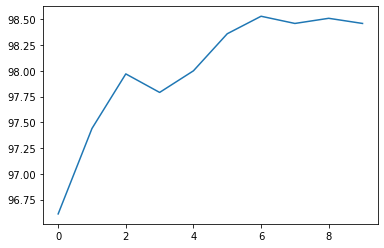

In [12]:
trained_net = train(num_epoch=10)

## Saving the model


In [13]:
torch.save(trained_net, "MNIST_Digit_Prediction_Model")

In [14]:
digits_model = torch.load("MNIST_Digit_Prediction_Model")
digits_model.eval()

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Tanh()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Tanh()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

## Creating the Function to test validation data


In [15]:
def predict_val_data(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        # print("value = ",value.shape)
        # print("pred = ",pred.shape)
        # print("labels = ",list(labels.numpy()))
        y_pred.extend(list(pred.data.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [16]:
y_pred, y_true = predict_val_data(digits_model, testloader)

## Getting any digit's image from the web and predicting it

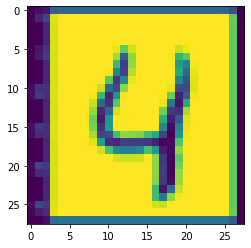

In [29]:
# path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg" # White Bg
path = "https://miro.medium.com/max/1280/1*KBue-jN2Z2hxvIW8T963yA.png" # Black Bg
r = requests.get(path)
# invert the image if it has white background as we have our model trained on black background.
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
# x = (255 - np.expand_dims(np.array(img), -1))/255.
x = (np.expand_dims(np.array(img), -1))/255.

plt.imshow(x.squeeze(-1))

In [30]:
import torch.nn.functional as F

def predict_real_img(path, model):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        # x = (255 - np.expand_dims(np.array(img), -1))/255.
        x = (np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float())
        return F.softmax(pred, dim=-1).numpy()

In [31]:
pred = predict_real_img(path, digits_model)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")
pred

Predicted: 4, Prob: 99.98573064804077 %


array([[1.7765484e-07, 4.9319560e-08, 1.3522159e-06, 9.0445758e-09,
        9.9985731e-01, 7.2376857e-08, 9.6283600e-07, 5.9332751e-07,
        2.4424142e-07, 1.3917353e-04]], dtype=float32)